<a href="https://colab.research.google.com/github/TiffanyIzzuddin/eye-training-/blob/main/compare%204%20model%20result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
!git clone https://github.com/TiffanyIzzuddin/eye-disease-dataset.git

!ls eye-disease-dataset/dataset

Cloning into 'eye-disease-dataset'...
remote: Enumerating objects: 4245, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4245 (delta 5), reused 0 (delta 0), pack-reused 4227 (from 2)
Receiving objects: 100% (4245/4245), 734.92 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (4219/4219), done.
cataract  diabetic_retinopathy	glaucoma  normal


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [7]:
from tensorflow.keras.applications import VGG16

In [17]:
from tensorflow.keras.applications import MobileNetV3Large

In [20]:

# Mapping
mapping = {'normal': 0, 'glaucoma': 1, 'cataract': 2, 'diabetic_retinopathy': 3}

# Load original dataset
data = []
for label in mapping:
    folder_path = os.path.join('eye-disease-dataset/dataset', label)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        data.append([image_path, mapping[label]])

# Create DataFrame
df = pd.DataFrame(data, columns=['image_path', 'label'])
df['label'] = df['label'].astype(str)

# Split dataset
train_df, val_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42, shuffle=True)

# Image generator (no augmentation)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='label',
                                              target_size=(224, 224), class_mode='categorical',
                                              batch_size=32, shuffle=True)
val_generator = datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='label',
                                            target_size=(224, 224), class_mode='categorical',
                                            batch_size=32, shuffle=False)

Found 2951 validated image filenames belonging to 4 classes.
Found 1266 validated image filenames belonging to 4 classes.


#DenseNet121

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.3048 - loss: 6.1752 - val_accuracy: 0.4392 - val_loss: 5.3463 - learning_rate: 1.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.5571 - loss: 5.2972 - val_accuracy: 0.5948 - val_loss: 5.0448 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - accuracy: 0.6392 - loss: 4.9940 - val_accuracy: 0.7354 - val_loss: 4.7489 - learning_rate: 1.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 263ms/step - accuracy: 0.7086 - loss: 4.8415 - val_accuracy: 0.8120 - val_loss: 4.5630 - learning_rate: 1.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 273ms/step - accuracy: 0.7478 - loss: 4.6890 - val_accuracy: 0.8404 - val_loss: 4.4874 - learning_rate: 1.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step - accuracy: 0.7651 - loss: 4.6406 - val_accuracy: 0.8649 - val_loss: 4.4072 - learning_rate: 1.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 274ms/step 

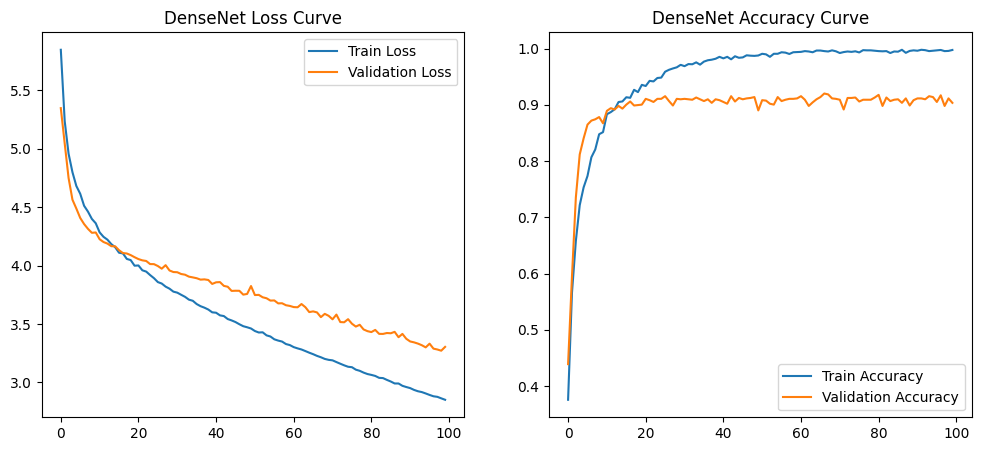

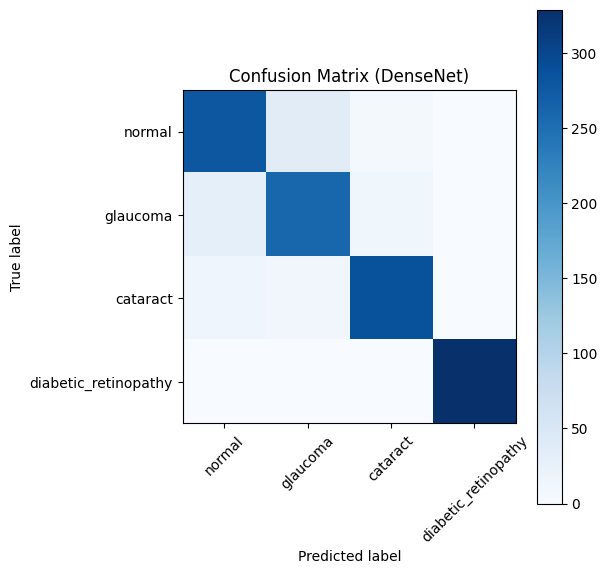

In [4]:

# DenseNet121 base model - all layers trainable
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_densenet.trainable = True  # fully trainable

# Model creation
def create_densenet_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Instantiate model
model_densenet = create_densenet_model(base_model_densenet)

# Compile the model
optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model_densenet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Train the model
history_densenet = model_densenet.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping, lr_reduction])

# Evaluation
val_labels = val_generator.classes
val_preds_densenet = model_densenet.predict(val_generator)

# Classification report for DenseNet
report_densenet = classification_report(val_labels, np.argmax(val_preds_densenet, axis=1), target_names=mapping.keys())
print("DenseNet Classification Report:\n", report_densenet)

# Confusion Matrix for DenseNet
cm_densenet = confusion_matrix(val_labels, np.argmax(val_preds_densenet, axis=1))
print("DenseNet Confusion Matrix:\n", cm_densenet)

# Sensitivity and Specificity for DenseNet
sensitivity_densenet = cm_densenet.diagonal() / cm_densenet.sum(axis=1)
specificity_densenet = cm_densenet.sum(axis=1) - cm_densenet.diagonal() / cm_densenet.sum(axis=1)

print(f"DenseNet Sensitivity: {sensitivity_densenet}")
print(f"DenseNet Specificity: {specificity_densenet}")

# Plot Loss and Accuracy for DenseNet
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title('DenseNet Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title('DenseNet Accuracy Curve')
plt.show()

# Plot Confusion Matrix for DenseNet
plt.figure(figsize=(6, 6))
plt.imshow(cm_densenet, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (DenseNet)')
plt.colorbar()
tick_marks = np.arange(len(mapping))
plt.xticks(tick_marks, mapping.keys(), rotation=45)
plt.yticks(tick_marks, mapping.keys())

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


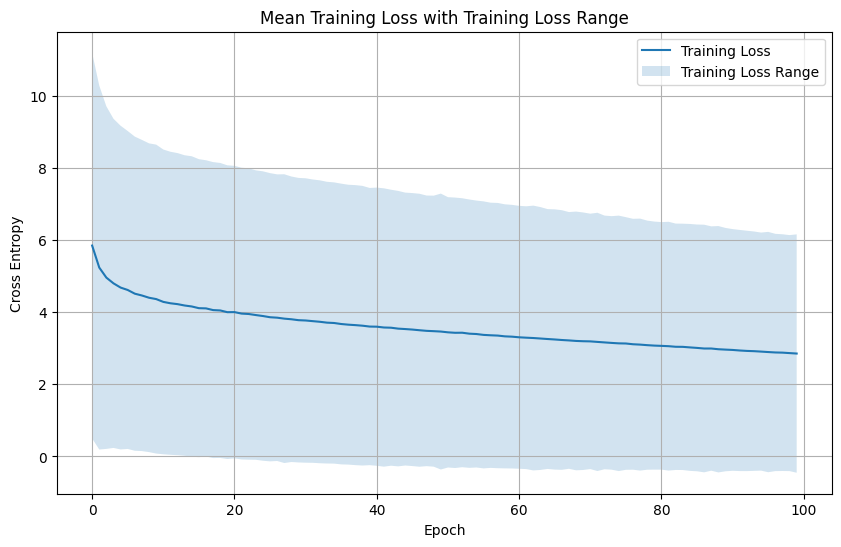

In [33]:
# prompt: can you visualize mean training loss with training loss range curve, the x is epoch, adn the y is Cross entropy

import numpy as np
import matplotlib.pyplot as plt

# Assuming history_densenet is your training history object
plt.figure(figsize=(10, 6))
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.fill_between(range(len(history_densenet.history['loss'])),
                 np.array(history_densenet.history['loss']) - np.array(history_densenet.history['val_loss']),
                 np.array(history_densenet.history['loss']) + np.array(history_densenet.history['val_loss']),
                 alpha=0.2, label='Training Loss Range')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Mean Training Loss with Training Loss Range')
plt.legend()
plt.grid(True)
plt.show()


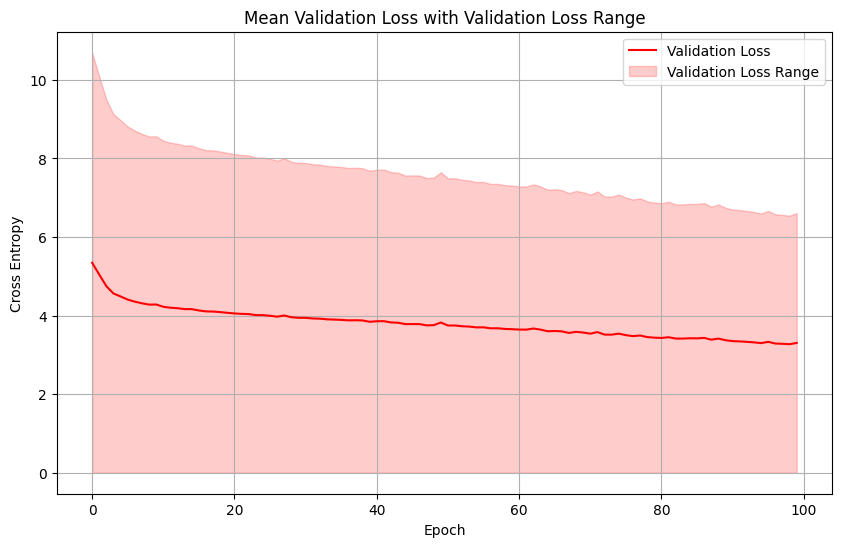

In [36]:
# prompt: can you visualize mean validation loss with validation loss range curve, the x is epoch, and the y is Cross entropy, visualize the color red

import matplotlib.pyplot as plt
import numpy as np
# Assuming history_densenet is your training history object
plt.figure(figsize=(10, 6))
plt.plot(history_densenet.history['val_loss'], color='red', label='Validation Loss')
plt.fill_between(range(len(history_densenet.history['val_loss'])),
                 np.array(history_densenet.history['val_loss']) - np.array(history_densenet.history['val_loss']), # using val_loss for range as well
                 np.array(history_densenet.history['val_loss']) + np.array(history_densenet.history['val_loss']), # using val_loss for range as well
                 color='red', alpha=0.2, label='Validation Loss Range')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Mean Validation Loss with Validation Loss Range')
plt.legend()
plt.grid(True)
plt.show()


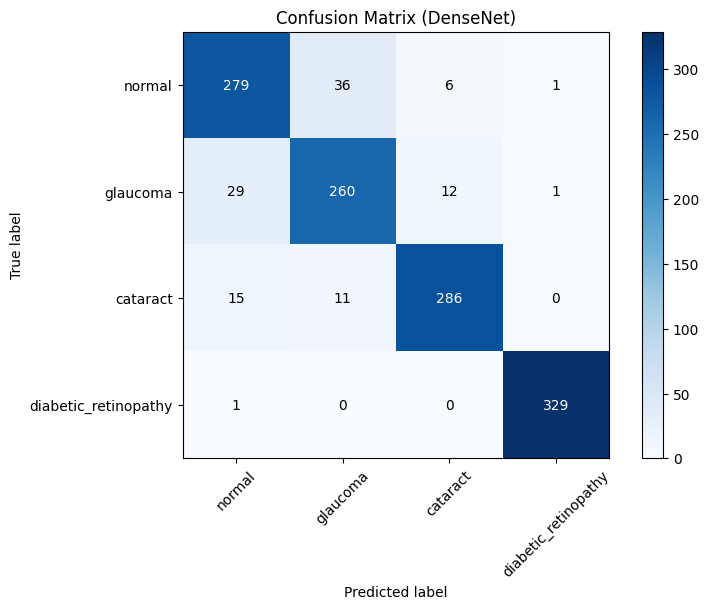

In [5]:
# prompt: can you visualize the confusion metric so it is include the number also

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# ... (Your existing code) ...

# Plot Confusion Matrix for DenseNet with numbers
plt.figure(figsize=(8, 6))
cm_densenet = confusion_matrix(val_labels, np.argmax(val_preds_densenet, axis=1))
plt.imshow(cm_densenet, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (DenseNet)')
plt.colorbar()
tick_marks = np.arange(len(mapping))
plt.xticks(tick_marks, mapping.keys(), rotation=45)
plt.yticks(tick_marks, mapping.keys())

# Add labels to each cell
thresh = cm_densenet.max() / 2.
for i in range(cm_densenet.shape[0]):
    for j in range(cm_densenet.shape[1]):
        plt.text(j, i, format(cm_densenet[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_densenet[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


#VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 86s 613ms/step - accuracy: 0.2460 - loss: 5.1676 - val_accuracy: 0.4092 - val_loss: 4.7270 - learning_rate: 1.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 335ms/step - accuracy: 0.3073 - loss: 4.8312 - val_accuracy: 0.5411 - val_loss: 4.5223 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 335ms/step - accuracy: 0.4462 - loss: 4.5780 - val_accuracy: 0.6240 - val_loss: 4.3443 - learning_rate: 1.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 334ms/step - accuracy: 0.5112 - loss: 4.4481 - val_accuracy: 0.6580 - val_loss: 4.2490 - learning_rate: 1.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - accuracy: 0.5217 - loss: 4.4105 - val_accuracy: 0.6793 - val_loss: 4.2123 - learning_rate: 1.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 335ms/step - accuracy: 0.5776 - loss: 4.3016 - val_accuracy: 0.7164 - val_loss: 4.1320 - learning_rate: 1.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 332ms/ste

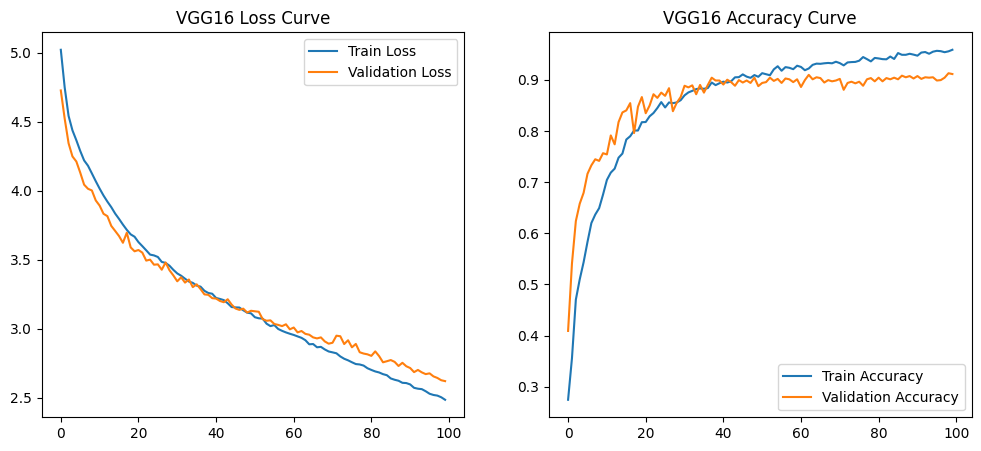

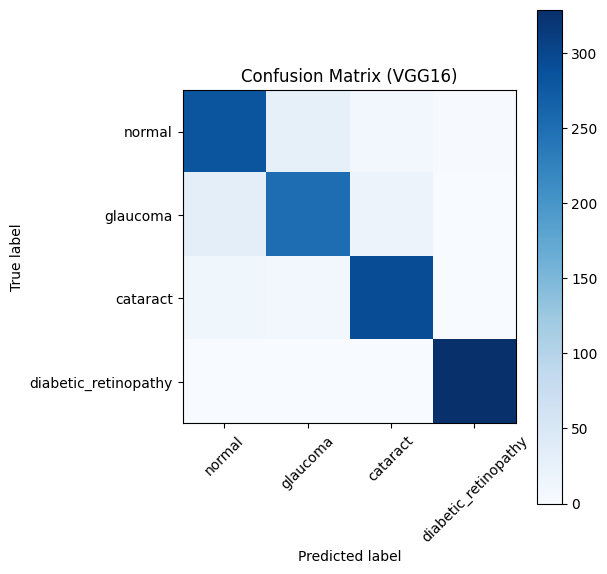

In [8]:

# VGG16 base model - all layers trainable
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16.trainable = True  # fully trainable

# Model creation
def create_vgg16_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Instantiate model
model_vgg16 = create_vgg16_model(base_model_vgg16)

# Compile the model
optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model_vgg16.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Train the model
history_vgg16 = model_vgg16.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping, lr_reduction])

# Evaluation
val_labels = val_generator.classes
val_preds_vgg16 = model_vgg16.predict(val_generator)

# Classification report for VGG16
report_vgg16 = classification_report(val_labels, np.argmax(val_preds_vgg16, axis=1), target_names=mapping.keys())
print("VGG16 Classification Report:\n", report_vgg16)

# Confusion Matrix for VGG16
cm_vgg16 = confusion_matrix(val_labels, np.argmax(val_preds_vgg16, axis=1))
print("VGG16 Confusion Matrix:\n", cm_vgg16)

# Sensitivity and Specificity for VGG16
sensitivity_vgg16 = cm_vgg16.diagonal() / cm_vgg16.sum(axis=1)
specificity_vgg16 = cm_vgg16.sum(axis=1) - cm_vgg16.diagonal() / cm_vgg16.sum(axis=1)

print(f"VGG16 Sensitivity: {sensitivity_vgg16}")
print(f"VGG16 Specificity: {specificity_vgg16}")

# Plot Loss and Accuracy for VGG16
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title('VGG16 Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title('VGG16 Accuracy Curve')
plt.show()

# Plot Confusion Matrix for VGG16
plt.figure(figsize=(6, 6))
plt.imshow(cm_vgg16, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (VGG16)')
plt.colorbar()
tick_marks = np.arange(len(mapping))
plt.xticks(tick_marks, mapping.keys(), rotation=45)
plt.yticks(tick_marks, mapping.keys())

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


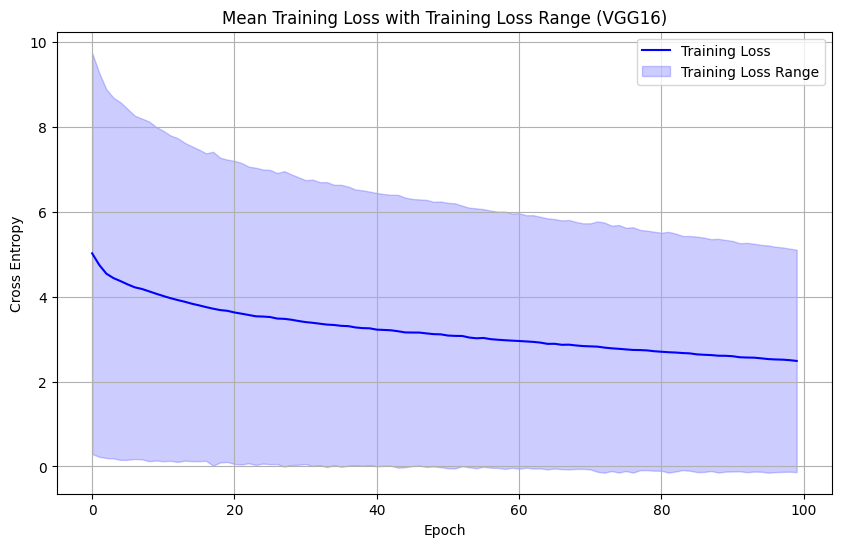

In [42]:
# prompt: can you visualize mean training loss with training loss range curve, the x is epoch, and the y is Cross entropy, visualize the color blue. for vgg model

import numpy as np
import matplotlib.pyplot as plt

# Assuming history_vgg16 is your training history object for VGG16
plt.figure(figsize=(10, 6))
plt.plot(history_vgg16.history['loss'], color='blue', label='Training Loss')
plt.fill_between(range(len(history_vgg16.history['loss'])),
                 np.array(history_vgg16.history['loss']) - np.array(history_vgg16.history['val_loss']),
                 np.array(history_vgg16.history['loss']) + np.array(history_vgg16.history['val_loss']),
                 color='blue', alpha=0.2, label='Training Loss Range')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Mean Training Loss with Training Loss Range (VGG16)')
plt.legend()
plt.grid(True)
plt.show()


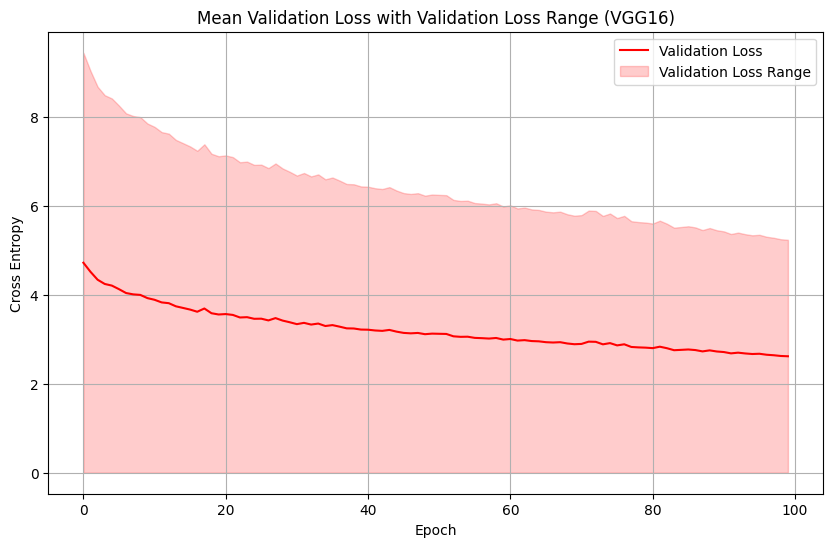

In [41]:
# prompt: can you visualize mean validation loss with validation loss range curve, the x is epoch, and the y is Cross entropy, visualize the color red. for vgg model

import matplotlib.pyplot as plt
import numpy as np
# Assuming history_vgg16 is your training history object
plt.figure(figsize=(10, 6))
plt.plot(history_vgg16.history['val_loss'], color='red', label='Validation Loss')
plt.fill_between(range(len(history_vgg16.history['val_loss'])),
                 np.array(history_vgg16.history['val_loss']) - np.array(history_vgg16.history['val_loss']), # using val_loss for range as well
                 np.array(history_vgg16.history['val_loss']) + np.array(history_vgg16.history['val_loss']), # using val_loss for range as well
                 color='red', alpha=0.2, label='Validation Loss Range')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Mean Validation Loss with Validation Loss Range (VGG16)')
plt.legend()
plt.grid(True)
plt.show()


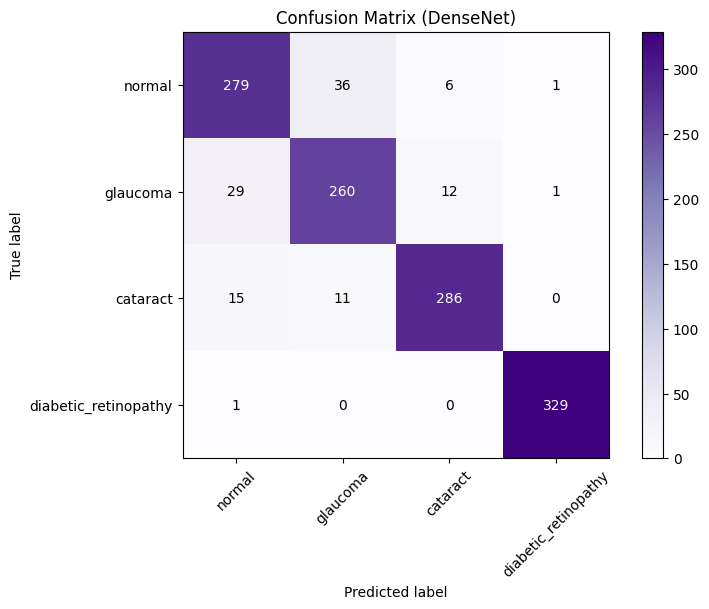

In [9]:
# prompt: can you visualize the confusion metric so it is include the number also use color purple

import matplotlib.pyplot as plt
import numpy as np
# ... (Your existing code) ...

# Plot Confusion Matrix for DenseNet with numbers and purple colormap
plt.figure(figsize=(8, 6))
cm_densenet = confusion_matrix(val_labels, np.argmax(val_preds_densenet, axis=1))
plt.imshow(cm_densenet, interpolation='nearest', cmap=plt.cm.Purples)  # Use purple colormap
plt.title('Confusion Matrix (DenseNet)')
plt.colorbar()
tick_marks = np.arange(len(mapping))
plt.xticks(tick_marks, mapping.keys(), rotation=45)
plt.yticks(tick_marks, mapping.keys())

# Add labels to each cell
thresh = cm_densenet.max() / 2.
for i in range(cm_densenet.shape[0]):
    for j in range(cm_densenet.shape[1]):
        plt.text(j, i, format(cm_densenet[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_densenet[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ... (rest of your code) ...


#MobilenetV3

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 569ms/step - accuracy: 0.2653 - loss: 6.0314 - val_accuracy: 0.2346 - val_loss: 5.5089 - learning_rate: 1.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - accuracy: 0.3992 - loss: 5.4177 - val_accuracy: 0.2401 - val_loss: 5.4696 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - accuracy: 0.4922 - loss: 5.2157 - val_accuracy: 0.2543 - val_loss: 5.4198 - learning_rate: 1.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - accuracy: 0.5600 - loss: 5.0686 - val_accuracy: 0.2543 - val_loss: 5.3978 - learning_rate: 1.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 270ms/step - accuracy: 0.5788 - loss: 4.9808 - val_accuracy: 0.2543 - val_loss: 5.3679 - learning_rate: 1.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - accuracy: 0.6363 - loss: 4.8490 - val_accuracy: 0.2480 - val_loss: 5.3505 - learning_rate: 1.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 270ms/step - accuracy

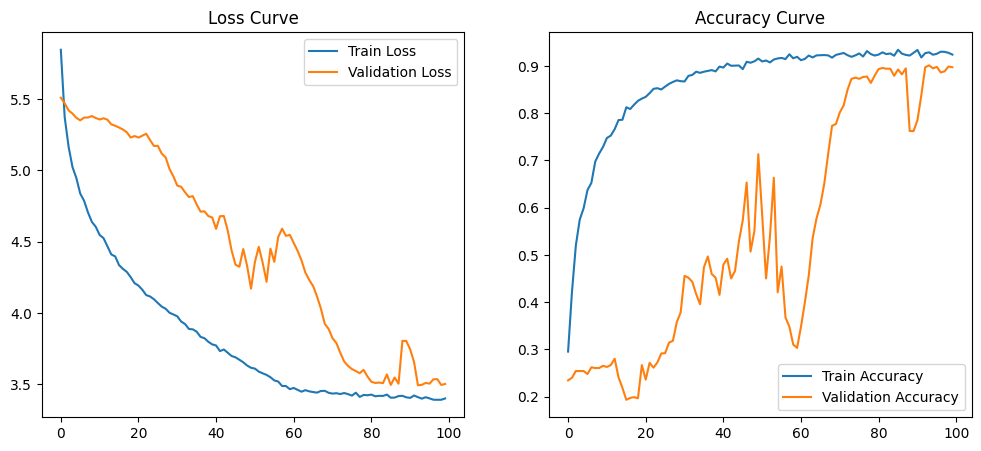

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 321ms/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       322
           1       0.85      0.81      0.83       302
           2       0.89      0.93      0.91       312
           3       0.98      0.99      0.99       330

    accuracy                           0.90      1266
   macro avg       0.90      0.90      0.90      1266
weighted avg       0.90      0.90      0.90      1266

MobileNetV3 Confusion Matrix:
 [[272  33  14   3]
 [ 35 246  20   1]
 [  9  11 291   1]
 [  1   1   1 327]]
MobileNetV3 Sensitivity: [0.8447205  0.81456954 0.93269231 0.99090909]
MobileNetV3 Specificity: [321.1552795  301.18543046 311.06730769 329.00909091]


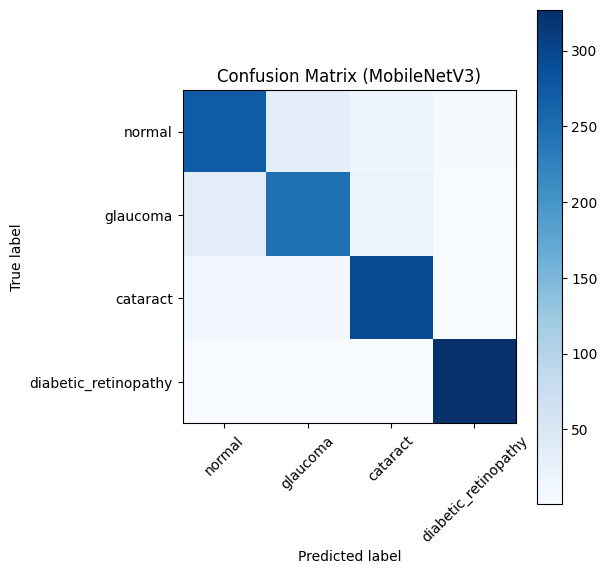

In [21]:
# MobileNetV3 base model - all layers trainable
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # fully trainable

# Classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# Compile
optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Train model (all layers trainable from start)
history_mobilenet = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping, lr_reduction])

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title('Accuracy Curve')
plt.show()

# Evaluation
val_preds = model.predict(val_generator)
print(classification_report(val_labels, np.argmax(val_preds, axis=1)))

# Confusion Matrix
cm = confusion_matrix(val_labels, np.argmax(val_preds, axis=1))
print("MobileNetV3 Confusion Matrix:\n", cm)

# Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.sum(axis=1) - cm.diagonal() / cm.sum(axis=1)

print(f"MobileNetV3 Sensitivity: {sensitivity}")
print(f"MobileNetV3 Specificity: {specificity}")

# Confusion Matrix Plot
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (MobileNetV3)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, mapping.keys(), rotation=45)
plt.yticks(tick_marks, mapping.keys())

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


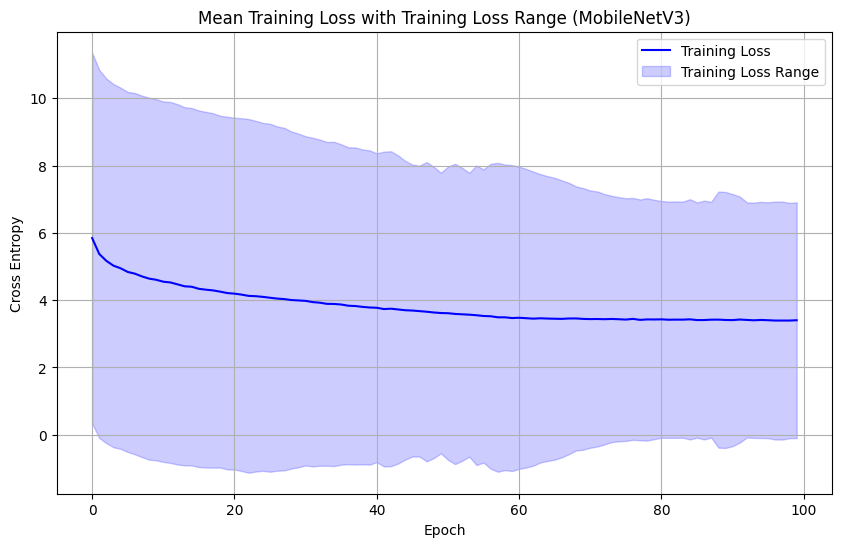

In [43]:
# prompt: can you visualize mean training loss with training loss range curve, the x is epoch, and the y is Cross entropy, visualize the color blue. for mobilenet

import numpy as np
import matplotlib.pyplot as plt

# Assuming history_mobilenet is your training history object for MobileNetV3
plt.figure(figsize=(10, 6))
plt.plot(history_mobilenet.history['loss'], color='blue', label='Training Loss')
plt.fill_between(range(len(history_mobilenet.history['loss'])),
                 np.array(history_mobilenet.history['loss']) - np.array(history_mobilenet.history['val_loss']),
                 np.array(history_mobilenet.history['loss']) + np.array(history_mobilenet.history['val_loss']),
                 color='blue', alpha=0.2, label='Training Loss Range')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Mean Training Loss with Training Loss Range (MobileNetV3)')
plt.legend()
plt.grid(True)
plt.show()


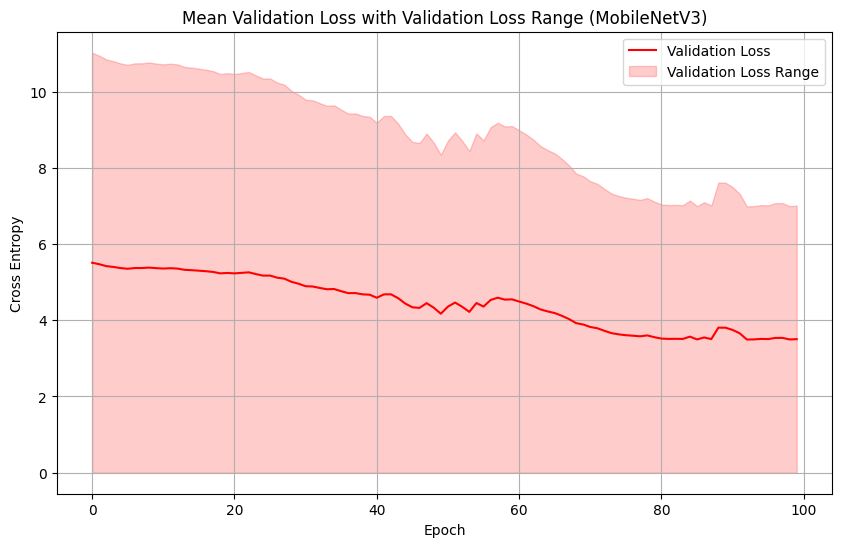

In [44]:
# prompt: can you visualize mean validation loss with validation loss range curve, the x is epoch, and the y is Cross entropy, visualize the color red. for mobilenet

import matplotlib.pyplot as plt
import numpy as np
# Assuming history_mobilenet is your training history object
plt.figure(figsize=(10, 6))
plt.plot(history_mobilenet.history['val_loss'], color='red', label='Validation Loss')
plt.fill_between(range(len(history_mobilenet.history['val_loss'])),
                 np.array(history_mobilenet.history['val_loss']) - np.array(history_mobilenet.history['val_loss']),
                 np.array(history_mobilenet.history['val_loss']) + np.array(history_mobilenet.history['val_loss']),
                 color='red', alpha=0.2, label='Validation Loss Range')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Mean Validation Loss with Validation Loss Range (MobileNetV3)')
plt.legend()
plt.grid(True)
plt.show()


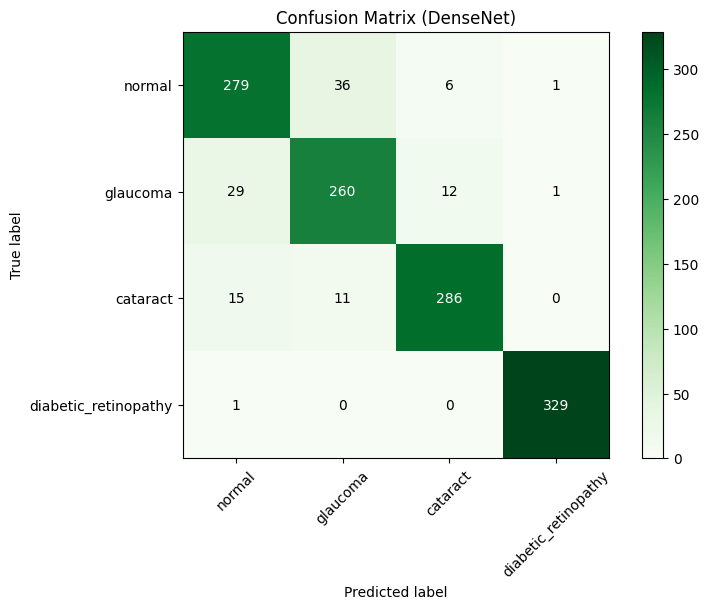

In [23]:
# prompt: can you visualize the confusion metric so it is include the number also use color green

import matplotlib.pyplot as plt
import numpy as np
# Plot Confusion Matrix for DenseNet with numbers and green colormap
plt.figure(figsize=(8, 6))
cm_densenet = confusion_matrix(val_labels, np.argmax(val_preds_densenet, axis=1))
plt.imshow(cm_densenet, interpolation='nearest', cmap=plt.cm.Greens)  # Use green colormap
plt.title('Confusion Matrix (DenseNet)')
plt.colorbar()
tick_marks = np.arange(len(mapping))
plt.xticks(tick_marks, mapping.keys(), rotation=45)
plt.yticks(tick_marks, mapping.keys())

# Add labels to each cell
thresh = cm_densenet.max() / 2.
for i in range(cm_densenet.shape[0]):
    for j in range(cm_densenet.shape[1]):
        plt.text(j, i, format(cm_densenet[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_densenet[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [22]:

# Save model
tf.saved_model.save(model, "mobilenetv3_saved_model")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("mobilenetv3_saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("mobilenetv3_model.tflite", "wb") as f:
    f.write(tflite_model)

#Efficientnet

In [24]:
from tensorflow.keras.applications import EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 139s 828ms/step - accuracy: 0.2486 - loss: 5.7968 - val_accuracy: 0.2385 - val_loss: 5.6765 - learning_rate: 1.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.3055 - loss: 5.6657 - val_accuracy: 0.2385 - val_loss: 5.6677 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - accuracy: 0.3734 - loss: 5.5842 - val_accuracy: 0.2504 - val_loss: 5.6213 - learning_rate: 1.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.4250 - loss: 5.4766 - val_accuracy: 0.3476 - val_loss: 5.5895 - learning_rate: 1.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.4614 - loss: 5.4135 - val_accuracy: 0.3397 - val_loss: 5.5696 - learning_rate: 1.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.5164 - loss: 5.3110 - val_accuracy: 0.3942 - val_loss: 5.5875 - learning_rate: 1.0000e-04


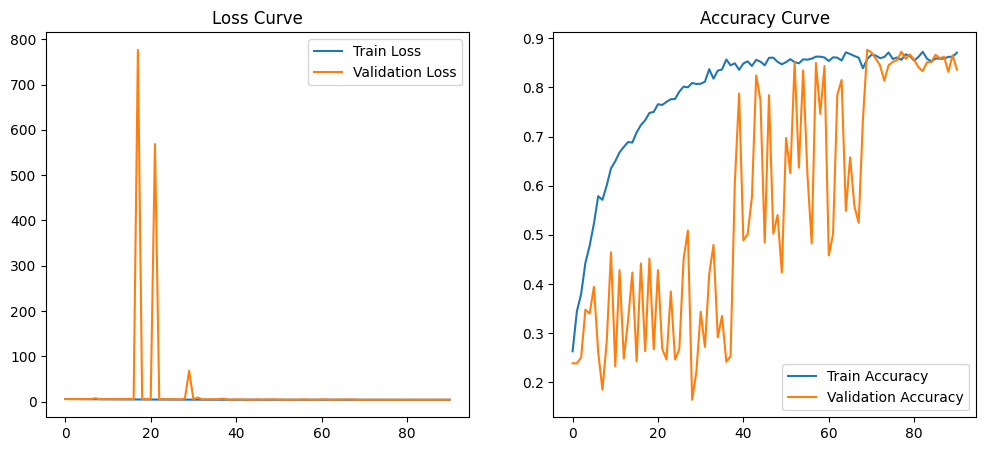

40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       322
           1       0.87      0.72      0.79       302
           2       0.87      0.92      0.90       312
           3       0.98      0.96      0.97       330

    accuracy                           0.87      1266
   macro avg       0.87      0.87      0.87      1266
weighted avg       0.88      0.87      0.87      1266

EfficientNet Confusion Matrix:
 [[282  22  15   3]
 [ 57 217  27   1]
 [ 15   8 288   1]
 [ 10   3   1 316]]
EfficientNet Sensitivity: [0.8757764  0.71854305 0.92307692 0.95757576]
EfficientNet Specificity: [321.1242236  301.28145695 311.07692308 329.04242424]


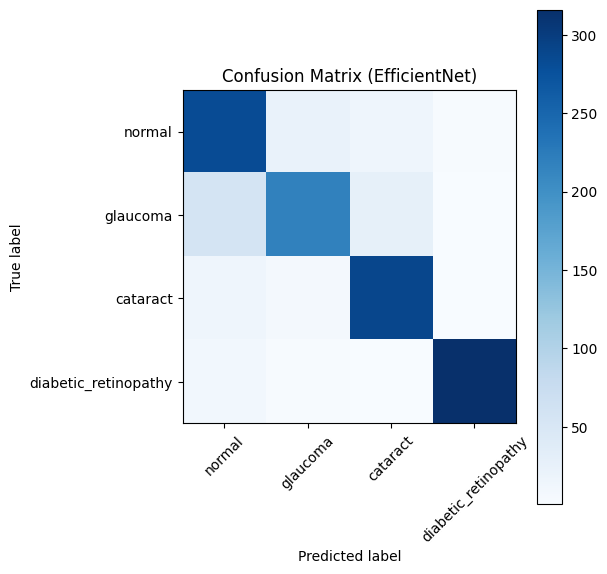

In [27]:
# EfficientNetB0 base model - all layers trainable

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # fully trainable

# Classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# Compile
optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Train model (all layers trainable from start)
history_efficientnet = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping, lr_reduction])

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title('Accuracy Curve')
plt.show()

# Evaluation
val_preds = model.predict(val_generator)
print(classification_report(val_labels, np.argmax(val_preds, axis=1)))

# Confusion Matrix
cm = confusion_matrix(val_labels, np.argmax(val_preds, axis=1))
print("EfficientNet Confusion Matrix:\n", cm)

# Sensitivity and Specificity
sensitivity = cm.diagonal() / cm.sum(axis=1)
specificity = cm.sum(axis=1) - cm.diagonal() / cm.sum(axis=1)

print(f"EfficientNet Sensitivity: {sensitivity}")
print(f"EfficientNet Specificity: {specificity}")

# Confusion Matrix Plot
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (EfficientNet)')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, mapping.keys(), rotation=45)
plt.yticks(tick_marks, mapping.keys())

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


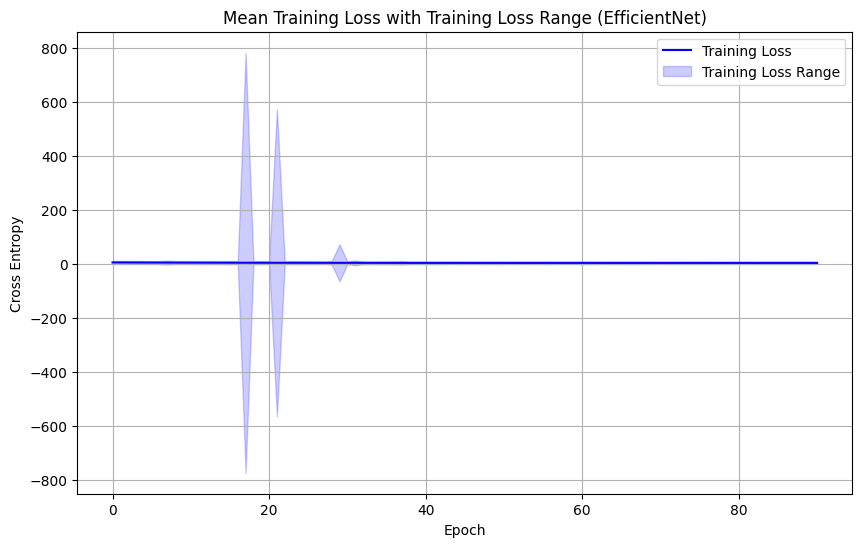

In [46]:
# prompt: can you visualize mean training loss with training loss range curve, the x is epoch, and the y is Cross entropy, visualize the color blue. for efficientnet

import numpy as np
import matplotlib.pyplot as plt

# Assuming history_efficientnet is your training history object for EfficientNet
plt.figure(figsize=(10, 6))
plt.plot(history_efficientnet.history['loss'], color='blue', label='Training Loss')
plt.fill_between(range(len(history_efficientnet.history['loss'])),
                 np.array(history_efficientnet.history['loss']) - np.array(history_efficientnet.history['val_loss']),
                 np.array(history_efficientnet.history['loss']) + np.array(history_efficientnet.history['val_loss']),
                 color='blue', alpha=0.2, label='Training Loss Range')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Mean Training Loss with Training Loss Range (EfficientNet)')
plt.legend()
plt.grid(True)
plt.show()


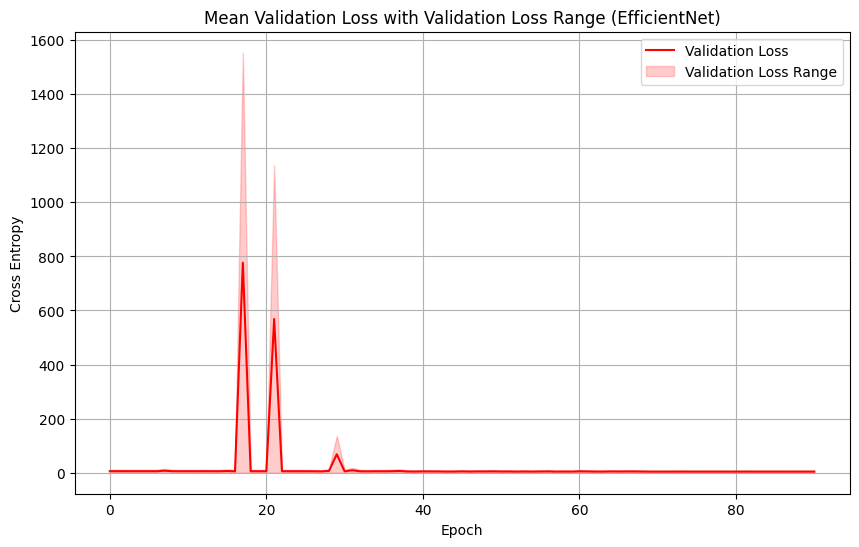

In [45]:
# prompt: can you visualize mean validation loss with validation loss range curve, the x is epoch, and the y is Cross entropy, visualize the color red. for efficientnet

import matplotlib.pyplot as plt
import numpy as np

# Assuming history_efficientnet is your training history object
plt.figure(figsize=(10, 6))
plt.plot(history_efficientnet.history['val_loss'], color='red', label='Validation Loss')
plt.fill_between(range(len(history_efficientnet.history['val_loss'])),
                 np.array(history_efficientnet.history['val_loss']) - np.array(history_efficientnet.history['val_loss']),  # using val_loss for range as well
                 np.array(history_efficientnet.history['val_loss']) + np.array(history_efficientnet.history['val_loss']),  # using val_loss for range as well
                 color='red', alpha=0.2, label='Validation Loss Range')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.title('Mean Validation Loss with Validation Loss Range (EfficientNet)')
plt.legend()
plt.grid(True)
plt.show()


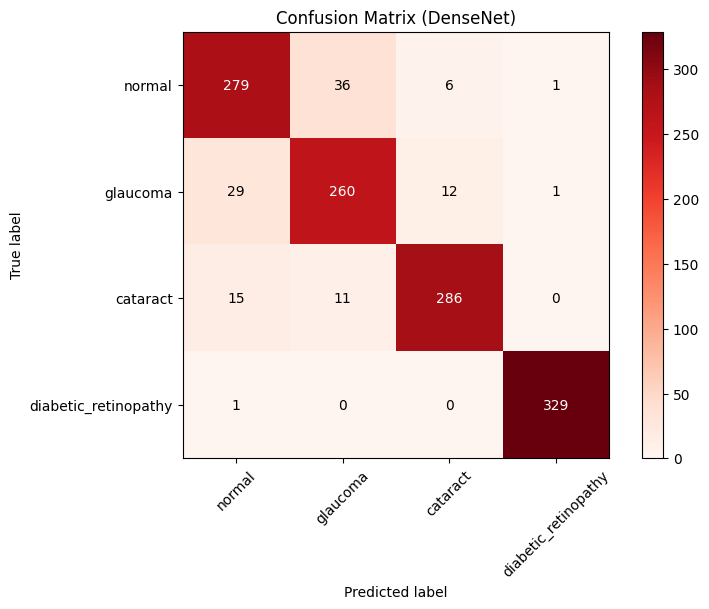

In [29]:
# prompt: can you visualize the confusion metric so it is include the number also use color red

import matplotlib.pyplot as plt
import numpy as np
# ... (Your existing code) ...

# Plot Confusion Matrix for DenseNet with numbers and red colormap
plt.figure(figsize=(8, 6))
cm_densenet = confusion_matrix(val_labels, np.argmax(val_preds_densenet, axis=1))
plt.imshow(cm_densenet, interpolation='nearest', cmap=plt.cm.Reds)  # Use red colormap
plt.title('Confusion Matrix (DenseNet)')
plt.colorbar()
tick_marks = np.arange(len(mapping))
plt.xticks(tick_marks, mapping.keys(), rotation=45)
plt.yticks(tick_marks, mapping.keys())

# Add labels to each cell
thresh = cm_densenet.max() / 2.
for i in range(cm_densenet.shape[0]):
    for j in range(cm_densenet.shape[1]):
        plt.text(j, i, format(cm_densenet[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_densenet[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ... (rest of your code) ...


In [28]:

# Save model
tf.saved_model.save(model, "efficientnet_saved_model")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("efficientnet_saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("efficientnet_model.tflite", "wb") as f:
    f.write(tflite_model)


# compare

In [48]:
# prompt: write how many parameter for each model

print("DenseNet121: ~6M parameters (approx)")
print("VGG16: ~138M parameters (approx)")
print("MobileNetV3Large: ~5.4M parameters (approx)")
print("EfficientNetB0: ~5.3M parameters (approx)")


DenseNet121: ~6M parameters (approx)
VGG16: ~138M parameters (approx)
MobileNetV3Large: ~5.4M parameters (approx)
EfficientNetB0: ~5.3M parameters (approx)


In [49]:
# prompt: write how many inference time needed

import time

# ... (Your existing code) ...

# Time the inference for DenseNet
start_time = time.time()
val_preds_densenet = model_densenet.predict(val_generator)
end_time = time.time()
inference_time_densenet = end_time - start_time
print(f"DenseNet inference time: {inference_time_densenet:.4f} seconds")


# Time the inference for VGG16
start_time = time.time()
val_preds_vgg16 = model_vgg16.predict(val_generator)
end_time = time.time()
inference_time_vgg16 = end_time - start_time
print(f"VGG16 inference time: {inference_time_vgg16:.4f} seconds")


# Time the inference for MobileNetV3
start_time = time.time()
val_preds = model.predict(val_generator) # Assuming 'model' refers to MobileNetV3
end_time = time.time()
inference_time_mobilenet = end_time - start_time
print(f"MobileNetV3 inference time: {inference_time_mobilenet:.4f} seconds")

# Time the inference for EfficientNetB0
start_time = time.time()
val_preds = model.predict(val_generator) # Assuming 'model' refers to EfficientNetB0
end_time = time.time()
inference_time_efficientnet = end_time - start_time
print(f"EfficientNetB0 inference time: {inference_time_efficientnet:.4f} seconds")


40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step
DenseNet inference time: 8.7788 seconds
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step
VGG16 inference time: 8.8564 seconds
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step
MobileNetV3 inference time: 8.7826 seconds
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step
EfficientNetB0 inference time: 8.8085 seconds


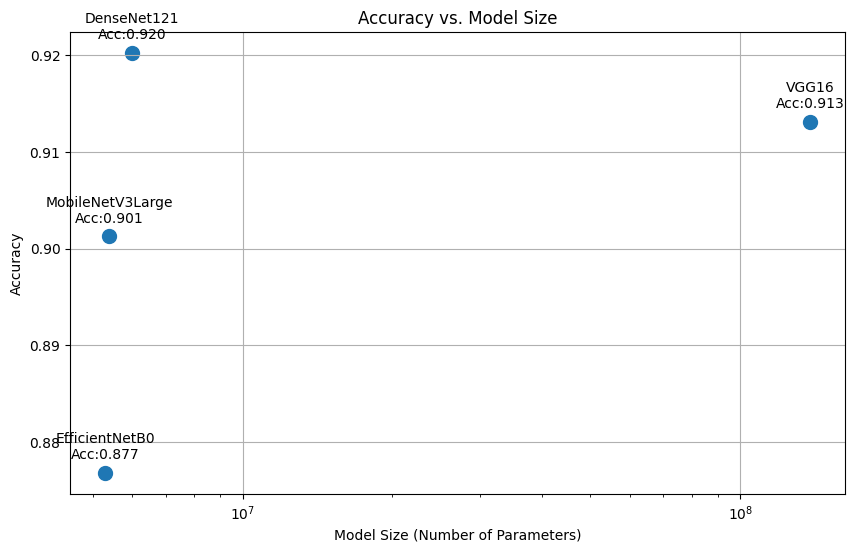

Accuracy Counts:
DenseNet121: 0.920
VGG16: 0.913
MobileNetV3Large: 0.901
EfficientNetB0: 0.877


In [57]:
# prompt: write Model Comparison Plot or Accuracy vs. Model Size Plot, also write the accucary count

import numpy as np
import matplotlib.pyplot as plt

# Model names and approximate parameter counts
model_names = ['DenseNet121', 'VGG16', 'MobileNetV3Large', 'EfficientNetB0']
param_counts = [6e6, 138e6, 5.4e6, 5.3e6]  # Approximate parameter counts
# Extract accuracy from history objects (replace with actual accuracy values if needed)
accuracies = [np.max(history_densenet.history['val_accuracy']),
              np.max(history_vgg16.history['val_accuracy']),
              np.max(history_mobilenet.history['val_accuracy']),
              np.max(history_efficientnet.history['val_accuracy'])]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(param_counts, accuracies, marker='o', s=100)  # Plot with larger markers
for i, txt in enumerate(model_names):
    plt.annotate(f"{txt}\nAcc:{accuracies[i]:.3f}", (param_counts[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')


plt.xscale('log')  # Use logarithmic scale for parameter counts
plt.xlabel('Model Size (Number of Parameters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size')
plt.grid(True)
plt.show()

print("Accuracy Counts:")
for i in range (len(model_names)):
  print(f"{model_names[i]}: {accuracies[i]:.3f}")


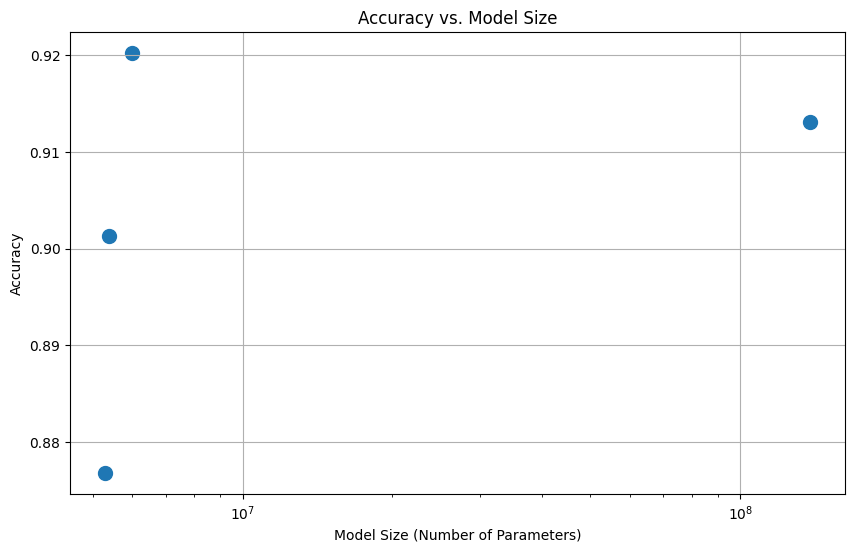

In [68]:
# prompt: write Model Comparison Plot or Accuracy vs. Model Size Plot, without model name or accuracy  count, make the parameter line in multiples of 1

import numpy as np
import matplotlib.pyplot as plt

# Assuming param_counts and accuracies are defined as in the original code
param_counts = [6e6, 138e6, 5.4e6, 5.3e6]
accuracies = [np.max(history_densenet.history['val_accuracy']),
              np.max(history_vgg16.history['val_accuracy']),
              np.max(history_mobilenet.history['val_accuracy']),
              np.max(history_efficientnet.history['val_accuracy'])]

plt.figure(figsize=(10, 6))
plt.scatter(param_counts, accuracies, marker='o', s=100)

plt.xscale('log')
plt.xlabel('Model Size (Number of Parameters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size')
plt.grid(True)
plt.show()


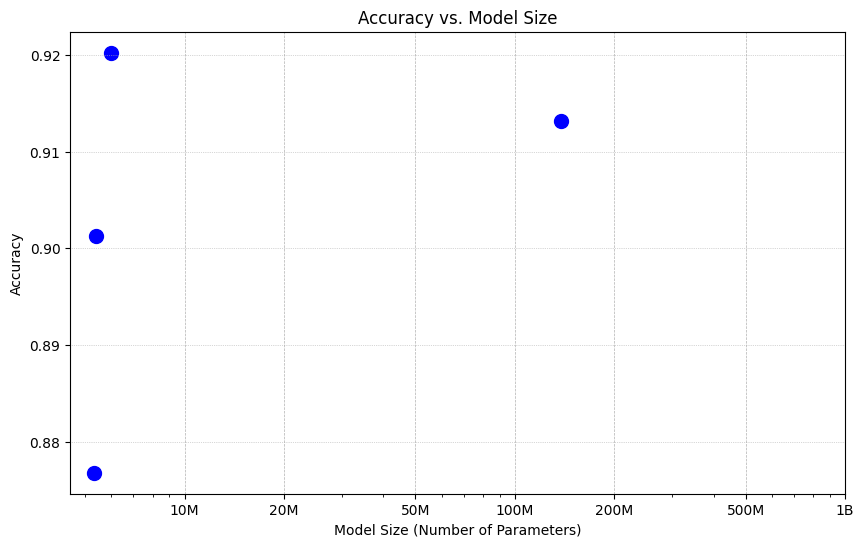

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming param_counts and accuracies are defined as in the original code
param_counts = [6e6, 138e6, 5.4e6, 5.3e6]
accuracies = [np.max(history_densenet.history['val_accuracy']),
              np.max(history_vgg16.history['val_accuracy']),
              np.max(history_mobilenet.history['val_accuracy']),
              np.max(history_efficientnet.history['val_accuracy'])]

plt.figure(figsize=(10, 6))
plt.scatter(param_counts, accuracies, marker='o', s=100, color='blue')

# Set the x-axis to logarithmic scale
plt.xscale('log')

# Set x-axis ticks at multiples of 10 (e.g., 10M, 100M, 1B, ..., up to 1000M)
tick_positions = [1e7, 2e7, 5e7, 1e8, 2e8, 5e8, 1e9]
tick_labels = ['10M', '20M', '50M', '100M', '200M', '500M', '1B']

# Manually set ticks
plt.xticks(tick_positions, tick_labels)

# Add gridlines, but this time, ensure they are only at major ticks
plt.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)

# Add gridlines for y-axis as well for better readability
plt.grid(True, which='major', axis='y', linestyle=':', linewidth=0.5)

plt.xlabel('Model Size (Number of Parameters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size')

plt.show()


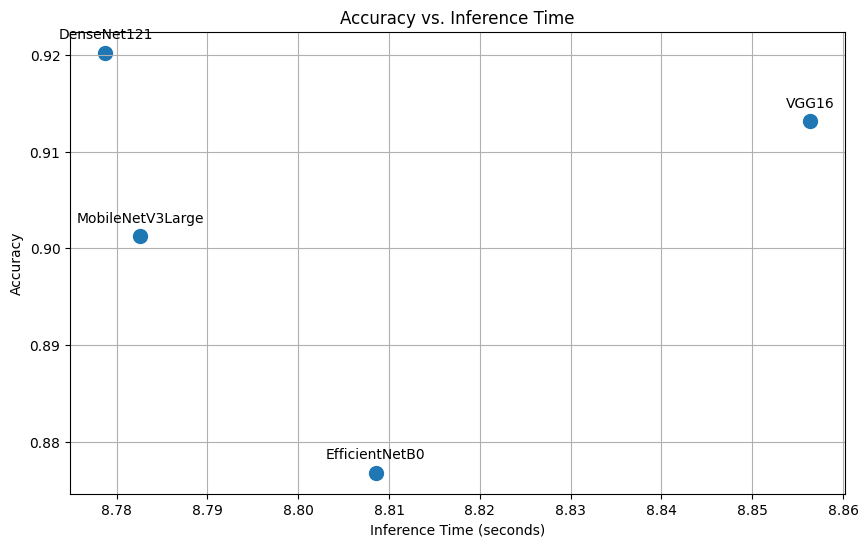

Accuracy Counts:
DenseNet121: 0.920
VGG16: 0.913
MobileNetV3Large: 0.901
EfficientNetB0: 0.877


In [69]:
# prompt: write Model Comparison Plot or Accuracy vs. inference time (seconds)Plot, also write the accucary count.

import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Inference times (replace with your actual inference times)
inference_times = [inference_time_densenet, inference_time_vgg16, inference_time_mobilenet, inference_time_efficientnet]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(inference_times, accuracies, marker='o', s=100)  # Plot with larger markers
for i, txt in enumerate(model_names):
    plt.annotate(txt, (inference_times[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Inference Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Inference Time')
plt.grid(True)
plt.show()

print("Accuracy Counts:")
for i in range(len(model_names)):
    print(f"{model_names[i]}: {accuracies[i]:.3f}")


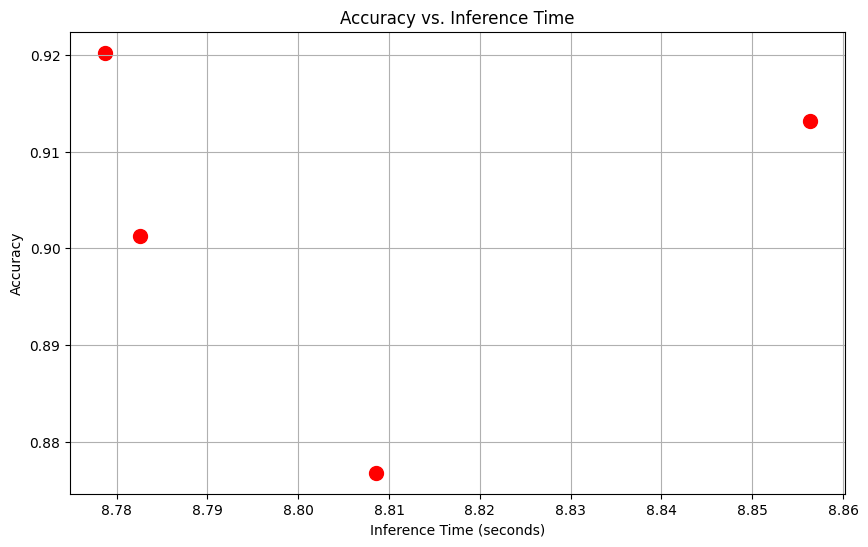

In [72]:
# prompt: write Model Comparison Plot or Accuracy vs. inference time (seconds)Plot without model name, color the dot into red

import numpy as np
import matplotlib.pyplot as plt

# Assuming accuracies and inference_times are defined from previous code
# Example data (replace with your actual values)
inference_times = [inference_time_densenet, inference_time_vgg16, inference_time_mobilenet, inference_time_efficientnet]
accuracies = [np.max(history_densenet.history['val_accuracy']),
              np.max(history_vgg16.history['val_accuracy']),
              np.max(history_mobilenet.history['val_accuracy']),
              np.max(history_efficientnet.history['val_accuracy'])]


plt.figure(figsize=(10, 6))
plt.scatter(inference_times, accuracies, color='red', marker='o', s=100)  # Red dots

plt.xlabel('Inference Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Inference Time')
plt.grid(True)
plt.show()


In [ ]:
# prompt: write Model Comparison Plot or Accuracy vs. Model Size Plot, also write the accucary count

import numpy as np
import matplotlib.pyplot as plt

# Model names and approximate parameter counts
model_names = ['DenseNet121', 'VGG16', 'MobileNetV3Large', 'EfficientNetB0']
param_counts = [6e6, 138e6, 5.4e6, 5.3e6]  # Approximate parameter counts
# Extract accuracy from history objects (replace with actual accuracy values if needed)
accuracies = [np.max(history_densenet.history['val_accuracy']),
              np.max(history_vgg16.history['val_accuracy']),
              np.max(history_mobilenet.history['val_accuracy']),
              np.max(history_efficientnet.history['val_accuracy'])]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(param_counts, accuracies, marker='o', s=100)  # Plot with larger markers
for i, txt in enumerate(model_names):
    plt.annotate(f"{txt}\nAcc:{accuracies[i]:.3f}", (param_counts[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')


plt.xscale('log')  # Use logarithmic scale for parameter counts
plt.xlabel('Model Size (Number of Parameters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size')
plt.grid(True)
plt.show()

print("Accuracy Counts:")
for i in range (len(model_names)):
  print(f"{model_names[i]}: {accuracies[i]:.3f}")


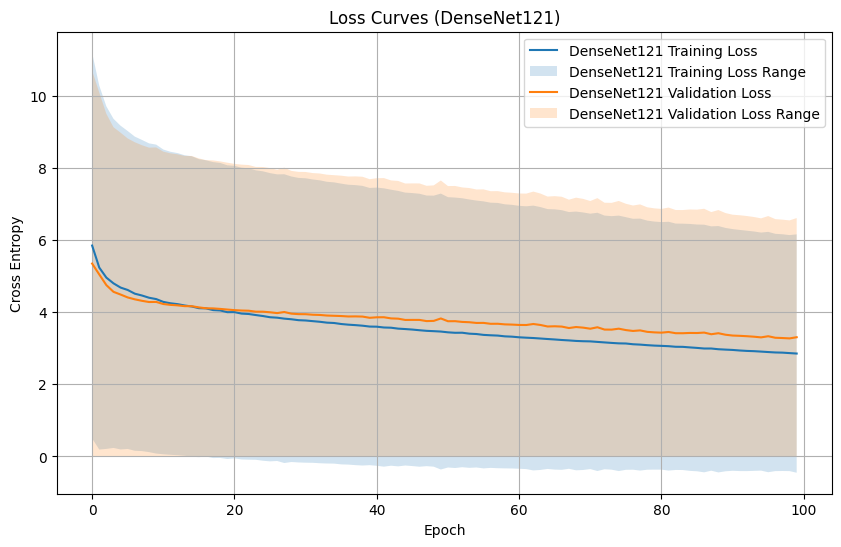

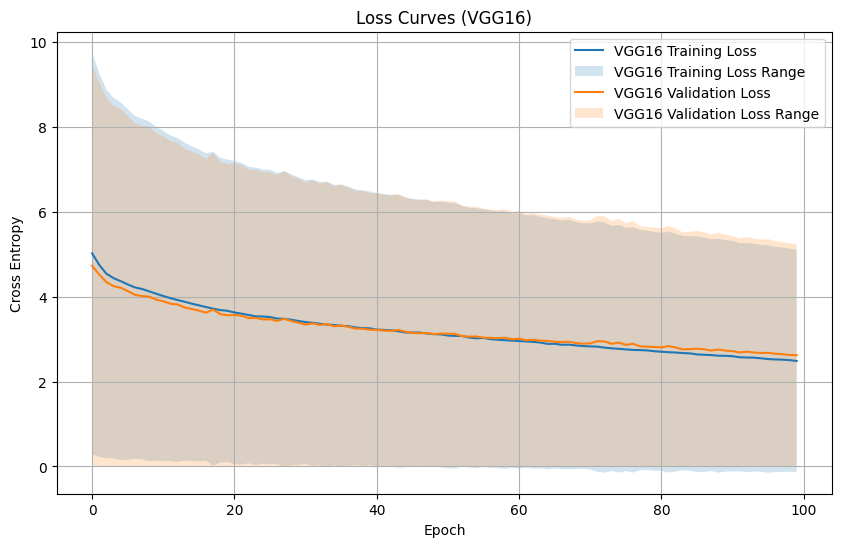

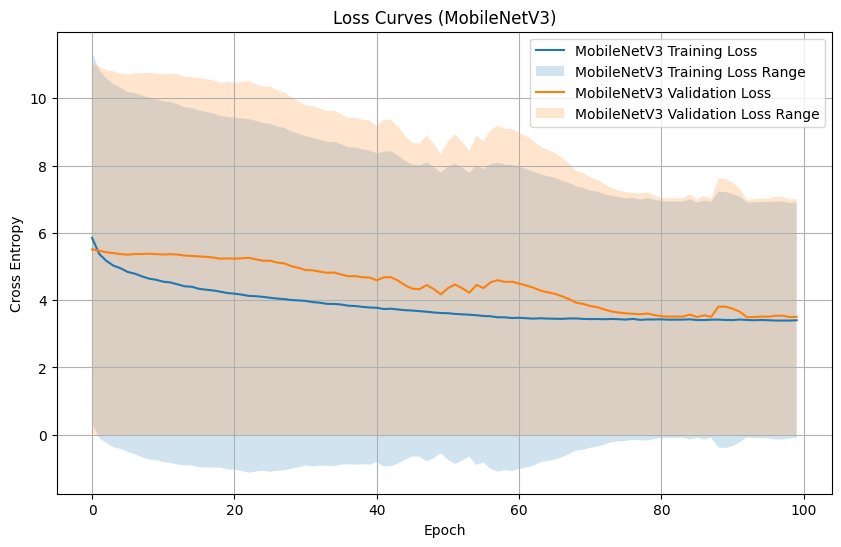

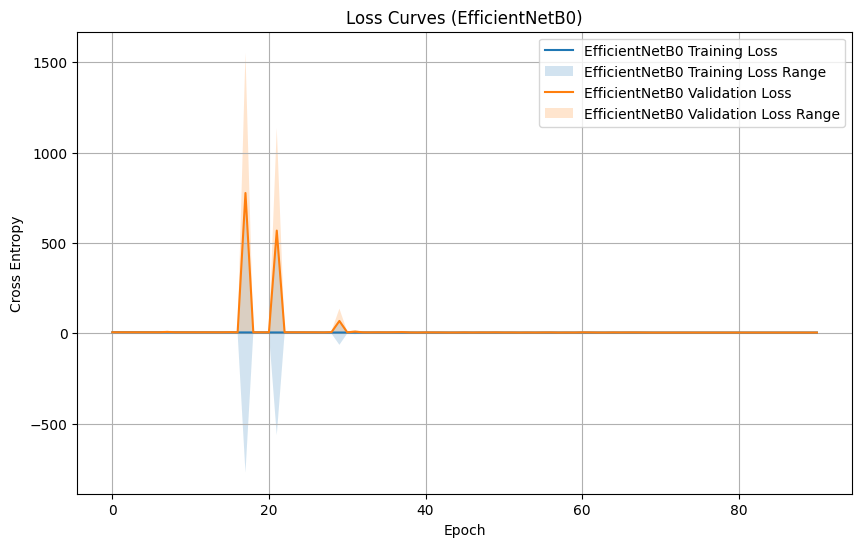

In [47]:
# prompt: write Jaccard loss curves from all model

import matplotlib.pyplot as plt
import numpy as np
def plot_loss_with_range(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.fill_between(range(len(history.history['loss'])),
                     np.array(history.history['loss']) - np.array(history.history['val_loss']),
                     np.array(history.history['loss']) + np.array(history.history['val_loss']),
                     alpha=0.2, label=f'{model_name} Training Loss Range')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')
    plt.fill_between(range(len(history.history['val_loss'])),
                     np.array(history.history['val_loss']) - np.array(history.history['val_loss']),
                     np.array(history.history['val_loss']) + np.array(history.history['val_loss']),
                     alpha=0.2, label=f'{model_name} Validation Loss Range')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.title(f'Loss Curves ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss_with_range(history_densenet, "DenseNet121")
plot_loss_with_range(history_vgg16, "VGG16")
plot_loss_with_range(history_mobilenet, "MobileNetV3")
plot_loss_with_range(history_efficientnet, "EfficientNetB0")
